In [1]:
# !pip install matplotlib

In [2]:
# !pip install awkward

In [ ]:
import numpy as np
import pandas as pd
########################################################################
########################################################################
########################################################################
def random_Transition_matrix(m):#, recursive=True
    """
    Generates a random NumPy matrix of size m x m with nonnegative elements.
    Args:
    m (int): The number of rows, columns in the matrix.
    Returns:
    numpy.ndarray: A random NumPy matrix of size m x m with nonnegative elements, where sum of element in each row is one.
    """
    matrix = np.random.rand(m, m)
    matrix= (matrix/matrix.sum(axis=0)).T
  # Convert the random values to integers to ensure nonnegativity
#   matrix = matrix.astype(np.float)

    return matrix
########################################################################
########################################################################
########################################################################
def PantryQueue(ParkingCapacity):
    N = 4 # number of food stations
    CarArrivalRatePerUnitTime = (65-16)/(3*60) # number of arrivals per iteration
    df_cars = pd.DataFrame(data=np.zeros(1), columns=["#NotProcessedPeopleInCar"])
    ProcessRate = 10 # max number of people can enter to stations line in each time unit
    MaxLength = 10000
    # ParkingCapacity = 20
    NumberOfCarsInParkingLine = 0
    EntranceLine_list = []
    ExitLine_list = []
    EntranceLineLength_list = [0]
    OccupiedParking_list = [0]
    ParkingWaitingLineLength_list = [0]
    FullyProcessedPeople = np.zeros(N+1)

    # data = [[[],]*N]
    data =[[[],]*1]




    StationsNameList = [(i) for i in range(N)]
    df_StationLines = pd.DataFrame(data, index=StationsNameList, columns=["CurrentLine"])
    df_StationLines.index.name = "StationNumber"

    df_StationWaitingTime = pd.DataFrame(data, index=StationsNameList, columns=["WaitingTime"])
    df_StationWaitingTime.index.name = "StationNumber"

    df_StationLineLength = pd.DataFrame(0, index=StationsNameList, columns=["LineLength"])
    df_StationLineLength.index.name = "StationNumber"

    df_StationServers = pd.DataFrame([3, 3, 3, 7], index=StationsNameList, columns=["NumberOfServers"]) #(random_Transition_matrix(N)[0,:]*3).astype(int)+1
    df_StationServers.index.name="StationNumber"

    df_StationLineLength_History = df_StationLineLength.copy()
    df_StationLineLength_History.columns = ["0"]

    Init_state =  np.ones([N])/N #random_Transition_matrix(N)[0,:]
    new_state_prob = Init_state
    Transition_matrix = np.ones([N,N])/N # random_Transition_matrix(N)


    CarID = 0
    for CurrentTime in range(int(3*60)): # 3.5 Studied period of time
    ########################################################################
    ########        Process How Cars Enter they Parking         ############
    ########################################################################

        if (CurrentTime<3*60):#3*60*60 # Active hours
            if (CurrentTime==0): CurrentCarArrivalRate = 16 # to handle heavy right taled arrival
            else: CurrentCarArrivalRate = np.random.poisson(CarArrivalRatePerUnitTime, 1)[0]# number of car arrival rate

            NumberOfCarsInParkingLine += CurrentCarArrivalRate
            ParkingAvailbaleCapacity = ParkingCapacity-sum(df_cars.loc[:,"#NotProcessedPeopleInCar"]>0)

            if(ParkingAvailbaleCapacity<=0): # change it to when the parking has free spot
                NumberOfNewCarsEnteringTheParking = 0 #int(np.random.rand()*ArrivalRate)

            else:
                NumberOfNewCarsEnteringTheParking = min(ParkingAvailbaleCapacity, NumberOfCarsInParkingLine)
                NumberOfCarsInParkingLine -= NumberOfNewCarsEnteringTheParking



            # FullyProcessedPeople[0]=FullyProcessedPeople[0]+(CurrentCarArrivalRate-CurrentFeasibleCarArrivalRate) # it's not actually exactly fully processed,
                                                                                                   # but all who left beceause they had no available choice at their last step
                                                                                                   # [0] counts number of cars that left due to parking capacity constraints

            for NewCar in range(NumberOfNewCarsEnteringTheParking):
                NumberOfPeopleInCar= round(np.random.normal(loc=4, scale=1.0, size=None)) #2 np.random.randint(1, 6)
                df_cars.loc[CarID,"#NotProcessedPeopleInCar"] = NumberOfPeopleInCar
                for i in range(NumberOfPeopleInCar):
                    NewCarPeople = np.zeros([2,N+1])
                    NewCarPeople[1,-1] = CarID
                    NewCarPeople[0,-1] = list(np.random.exponential(4, 1))[0]
                    NewCarPeople[0,:-1] = list(np.random.exponential(5, 3))+ list(np.random.exponential(10, 1)) #[5*60, 5*60, 5*60, 10*60]  #(random_Transition_matrix(N)[0,:]*100).astype(int)+30 # we randomely generate the amount of time each person spends in each station server
                    if (np.random.rand()>0.25): NewCarPeople[0,3]=0 # only %25 of shoppers complete clothing (assume station 0 is for clothing)
                    EntranceLine_list = [NewCarPeople] + EntranceLine_list
                CarID+=1
            # print(NewCarPeople)

            # EntranceLine_list=[np.zeros([N])]*CurrentArrivalRate+EntranceLine_list # modify it that some of them will leave ...
        else:
            EntranceLine_list = EntranceLine_list # modify it that some of them will leave ...
            NumberOfCarsInParkingLine = 0

    ########################################################################
    ########      Process how people enter the startions' lines   ############
    ########################################################################
        # How many free spots are available in all stations, so we can atmost let that number in
        TotalFreeAvailableSpotInStations = MaxLength*N-df_StationLineLength.iloc[:, 0].sum()

        if(TotalFreeAvailableSpotInStations>0):
            ProcessNowRate = min(ProcessRate, len(EntranceLine_list), TotalFreeAvailableSpotInStations) # number of people enter to the end of sattions' lines
            for _ in range(ProcessNowRate):
                person_history = EntranceLine_list[-1].copy()
                del EntranceLine_list[-1]# remove this person from list of people in the entarnce line

                Adjusted_Init_state = np.zeros(N)
                FreeStationIndex = list(np.argwhere(df_StationLineLength<MaxLength)[:,0]) # find index of free stations
                FullStationIndex = list(np.argwhere(df_StationLineLength>=MaxLength)[:,0]) # find index of full stations
                FeasibleStationIndex = list (set(FreeStationIndex).intersection(set(list(np.argwhere(person_history[0,:-1]>0)[:,0]))))
                InFeasibleStationIndex = list (set(FullStationIndex).union(set(list(np.argwhere(person_history[0,:-1]<=0)[:,0]))))
                if(len(FeasibleStationIndex)>0):
                    # EmptyStationIndex = list((df_StationLineLength < 20).values)
                    Adjusted_Init_state[FeasibleStationIndex] = (0.001+Init_state[FeasibleStationIndex])/(Init_state[FeasibleStationIndex].sum()+0.001*len(FeasibleStationIndex))
                    Adjusted_Init_state[InFeasibleStationIndex] = 0

                    station = np.random.choice(StationsNameList, size=1, p=list(Adjusted_Init_state))[0]

                    # person_history[0,station]+=1
                    df_StationLines.iloc[station, 0] = [person_history] + df_StationLines.iloc[station, 0]
                    df_StationLineLength.iloc[station, 0]=len(df_StationLines.iloc[station, 0]) #df_StationLineLength.iloc[station, 0]+1

        for station in StationsNameList: df_StationLineLength.iloc[station, 0]=len(df_StationLines.iloc[station, 0])
    ########################################################################
    ########      Process how they transit and exit stations' lines   ############
    ########################################################################
        new_state_prob = np.dot(new_state_prob, Transition_matrix)
        NonEmptyStationIndex = list(np.argwhere(df_StationLineLength>0)[:,0])
        # print("777777", df_StationLineLength, NonEmptyStationIndex)
        # print('***', list(df_StationLineLength.iloc[NonEmptyStationIndex].index))

        for station in NonEmptyStationIndex: #list(df_StationLineLength.iloc[NonEmptyStationIndex].index):
            PeopleInStationLineOutOfServer = (df_StationLineLength.iloc[station, 0]-min(df_StationLineLength.iloc[station, 0], df_StationServers.iloc[station, 0]))
            for k in range(PeopleInStationLineOutOfServer):
                df_StationLines.iloc[station, 0][k][1,station]+=1 # add how many seconds this person is stating in this sation's line

            PeopleInStationServer = min(df_StationLineLength.iloc[station, 0], df_StationServers.iloc[station, 0])
            ServedPeople=0
            for k in range(PeopleInStationServer):

                # print(SationBusyServer, k)

                # print(df_StationLines.loc[station, ["CurrentLine"]])
                df_StationLines.iloc[station, 0][-k+ServedPeople-1][1,station]+=1 # add to see how many seconds this person is stating in this sation's line
                df_StationLines.iloc[station, 0][-k+ServedPeople-1][0,station]-=1 # deduct to see how many seconds this person left to be served by this sation's server
                if(df_StationLines.iloc[station, 0][-k+ServedPeople-1][0,station]<=0):
                    person_history = df_StationLines.iloc[station, 0][-k+ServedPeople-1].copy()
                    df_StationWaitingTime.iloc[station, 0]= [person_history[1,station]] + df_StationWaitingTime.iloc[station, 0]
                    del df_StationLines.iloc[station, 0][-k+ServedPeople-1]
                    ServedPeople +=1
                    df_StationLineLength.iloc[station, 0]=len(df_StationLines.iloc[station, 0]) #df_StationLineLength.iloc[station, 0]-1

            # Now the firt person in this line person goes to another station if she hasn't been to at laest one
                    OpenStationIndex = list (set(list(np.argwhere(df_StationLineLength<MaxLength)[:,0])).intersection(set(list(np.argwhere(person_history[0,:-1]>0)[:,0]))))
                    # print("888888   ", OpenStationIndex, station)
                    if(len(OpenStationIndex)>0): # check if the person has visited all stations
                        Current_state_prob = Transition_matrix[station, :].copy() #np.zeros(N) # list(set(x) - set(y))
                        # OpenStationIndex = list (set(list(np.argwhere(df_StationLineLength<MaxLength)[:,0])).intersection(set(list(np.argwhere(person_history>0)[:,0]))))
                        BlockedStationIndex = list (set(list(np.argwhere(df_StationLineLength>=MaxLength)[:,0])).union(set(list(np.argwhere(person_history[0,:-1]<=0)[:,0]))))
                        Current_state_prob[:]=(0.001+Current_state_prob[:])/(np.sum(Current_state_prob[:])+0.001*N)

                        Adjusted_current_state_prob=np.zeros(N)
                        Adjusted_current_state_prob[OpenStationIndex] = Current_state_prob[OpenStationIndex]/Current_state_prob[OpenStationIndex].sum()
                        Adjusted_current_state_prob[BlockedStationIndex]=0
                        new_station = np.random.choice(StationsNameList, size=1, p=list(Adjusted_current_state_prob))[0]
                        # print("\n **********   ",x,  new_station,(person_history), Adjusted_current_state_prob)
                        df_StationLines.iloc[new_station, 0] = [person_history] + df_StationLines.iloc[new_station, 0]
                        df_StationLineLength.iloc[new_station, 0] = len(df_StationLines.iloc[new_station, 0]) #df_StationLineLength.iloc[new_station, 0]+1


                    else:
                        # print(person_history)
                        ExitLine_list = [person_history]+ExitLine_list
                            `[int(sum(person_history[1,:-1]>0))]=FullyProcessedPeople[int(sum(person_history[1,:-1]>0))]+1 # it's not actually exactly fully processed, but all who left beceause they had no available choice at their last step
                        # PersonCarID=person_history[1,-1]

    ########################################################################
    ########        sumulate waiting time for people to get to the car         ############
    ########################################################################

        ServedPeople_=0
        CurrentExitLine_length=len(ExitLine_list)
        for kkk in range(CurrentExitLine_length):
            ExitLine_list[ServedPeople_-kkk-1][0,-1]=ExitLine_list[ServedPeople_-kkk-1][0,-1]-1
            # print(ExitLine_list[ServedPeople_-kkk-1])
            if(ExitLine_list[ServedPeople_-kkk-1][0,-1]<=0):
                PersonCarID=ExitLine_list[ServedPeople_-kkk-1][1,-1]
                # print(PersonCarID, "***", ExitLine_list[ServedPeople_-kkk-1], "\n\n")
                del ExitLine_list[ServedPeople_-kkk-1]
                ServedPeople_+=1
                df_cars.loc[PersonCarID,"#NotProcessedPeopleInCar"] = df_cars.loc[PersonCarID,"#NotProcessedPeopleInCar"]-1


                # state=np.dot(state,P)
                # print(state)
                # stateHist=np.append(stateHist,state,axis=0)
                # dfDistrHist = pd.DataFrame(stateHist)
                # dfDistrHist.plot()
                # plt.show()

        # print(df_StationLineLength)
        df_StationLineLength.columns=[str(CurrentTime+1)]
        df_StationLineLength_History=pd.concat([df_StationLineLength_History, df_StationLineLength], axis=1)
        EntranceLineLength_list=EntranceLineLength_list+[len(EntranceLine_list)]
        OccupiedParking_list=OccupiedParking_list+[sum(df_cars.loc[:,"#NotProcessedPeopleInCar"]>0)]
        ParkingWaitingLineLength_list=ParkingWaitingLineLength_list + [NumberOfCarsInParkingLine]



    df_StationLineLength_History.loc["EntranceLine"]=EntranceLineLength_list
    df_StationLineLength_History.loc["OccupiedParking"] =OccupiedParking_list
    df_StationLineLength_History.loc["ParkingWaitingLine"] =ParkingWaitingLineLength_list

    # df_StationLineLength_History.iloc[:,:].T.plot(figsize=(10, 5))
    # print(FullyProcessedPeople)
    return df_StationLineLength_History, df_StationWaitingTime, FullyProcessedPeople

a, b, c=PantryQueue(10)


In [ ]:
c

array([ 0.,  0.,  0., 65., 18.])

In [ ]:
np.mean(waitingtimeDF.loc[0][0]+waitingtimeDF.loc[1][0]+waitingtimeDF.loc[2][0]+waitingtimeDF.loc[3][0])
waitingtimeDF

NameError: name 'waitingtimeDF' is not defined

In [ ]:
df_InStoreWaitingTime = pd.DataFrame(columns = ['Avg Station 1', 'Avg Station 2', 'Avg Station 3', 'Avg Station 4'])
df_ParkingQueue = pd.DataFrame(columns = ['Avg #Full Parking','Avg Parking Queue'])
df_FullySerevedPeople = pd.DataFrame(columns = ['Avg #Full Served People'])


df_NumPeopleInStore
for k in range(10):
    i=5+5*k
    df_InStoreWaitingTime_i = pd.DataFrame(columns = ['Avg Station 1', 'Avg Station 2', 'Avg Station 3', 'Avg Station 4'])
    df_ParkingQueue_i = pd.DataFrame(columns = ['Avg #Full Parking','Avg Parking Queue'])
    list_FullySerevedPeople_i = []

    for j in range(30):
        df_StationLineLength_History, df_StationWaitingTime, array_FullySerevedPeople=PantryQueue(i)
        df_InStoreWaitingTime_i.loc[j]=[np.mean(df_StationWaitingTime.loc[0][0]),np.mean(df_StationWaitingTime.loc[1][0]),np.mean(df_StationWaitingTime.loc[2][0]),np.mean(df_StationWaitingTime.loc[3][0])]
        df_ParkingQueue_i.loc[j]=df_StationLineLength_History.iloc[-2:,:].mean(axis=1).values
        list_FullySerevedPeople_i+=[array_FullySerevedPeople.sum()]
    df_InStoreWaitingTime.loc[i]=df_InStoreWaitingTime_i.mean()
    df_ParkingQueue.loc[i]=df_ParkingQueue_i.mean()
    df_FullySerevedPeople.loc[i]=np.mean(list_FullySerevedPeople_i)

    # print(df_ParkingQueue)

C:\Users\mohammadreze\AppData\Local\Temp\ipykernel_4356\3853490108.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_InStoreWaitingTime_i.loc[j]=[np.mean(df_StationWaitingTime.loc[0][0]),np.mean(df_StationWaitingTime.loc[1][0]),np.mean(df_StationWaitingTime.loc[2][0]),np.mean(df_StationWaitingTime.loc[3][0])]
C:\Users\mohammadreze\AppData\Local\Temp\ipykernel_4356\3853490108.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_InStoreWaitingTime_i.loc[j]=[np.mean(df_StationWaitingTime.loc[0][0]),np.mean(df_StationWaitingTime.loc[1][0]),np.mean(df_StationWaitingTime.loc[2][0]),np.mean(df_StationWaitingTime.lo

<Axes: title={'center': 'Average Number of cars in the parking lot and queue throughout a 3-hour day'}, xlabel='#Parking Capacity', ylabel='#Cars'>

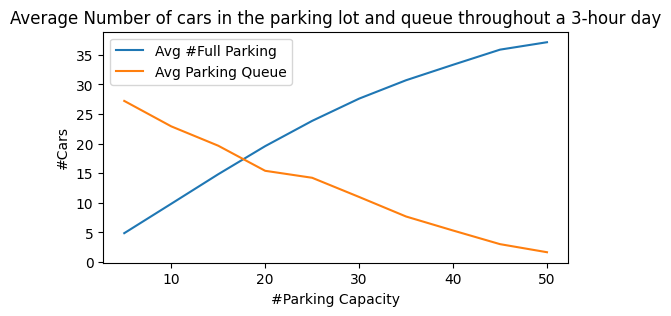

In [ ]:
df_ParkingQueue.plot(figsize=(6, 3), title='Average Number of cars in the parking lot and queue throughout a 3-hour day',xlabel= '#Parking Capacity',ylabel='#Cars' )

<Axes: title={'center': 'Average Shopping Waiting Time in a 3-hour day'}, xlabel='#Parking Capacity', ylabel='Minutes'>

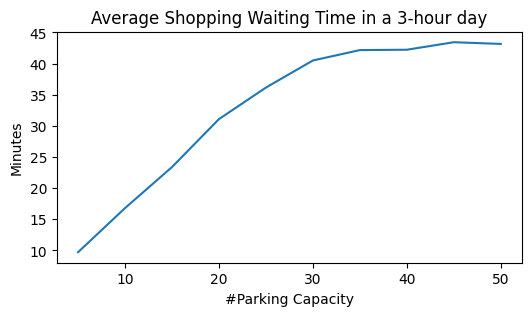

In [ ]:
df_InStoreWaitingTime.mean(axis=1).plot(figsize=(6, 3), title='Average Shopping Waiting Time in a 3-hour day',xlabel= '#Parking Capacity',ylabel='Minutes' )


<Axes: title={'center': 'Average fully serevd people throughout a 3-hour day'}, xlabel='#Parking Capacity', ylabel='#People'>

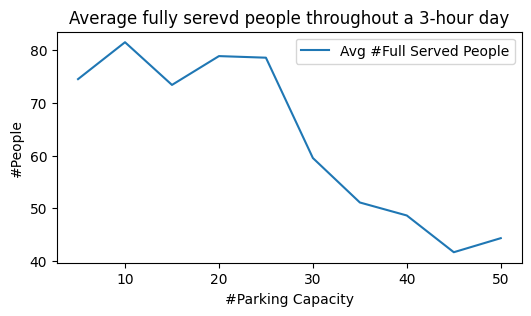

In [ ]:
df_FullySerevedPeople.plot(figsize=(6, 3), title='Average fully serevd people throughout a 3-hour day',xlabel= '#Parking Capacity',ylabel='#People' )

In [ ]:
df_NumPeopleInStore = pd.DataFrame(PantryQueue().iloc[:-3,:].T.sum(axis=1).copy())
df_NumCarInParkingQueue = pd.DataFrame(PantryQueue().iloc[-2:,:].T.copy())

df_NumPeopleInStore
for i in range(5,30):
    df_NumPeopleInStore[str(i)]=PantryQueue().iloc[:-3,:].T.sum(axis=1)#.plot(figsize=(10, 5))
    df_NumCarInParkingQueue+=PantryQueue().iloc[-2:,:].T#.plot(figsize=(10, 5))

<Axes: title={'center': 'Number of cars in the parking lot and queue throughout a 3-hour day'}, xlabel='Minute of the day', ylabel='#Cars'>

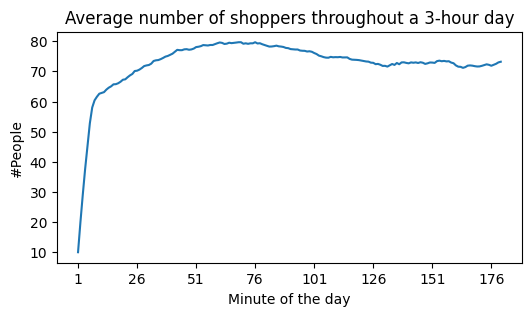

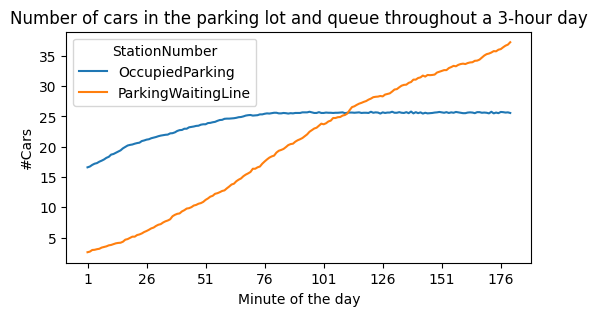

In [ ]:
import matplotlib as plt

df_NumPeopleInStore.mean(axis=1).iloc[1:].plot(figsize=(6, 3), title='Average number of shoppers throughout a 3-hour day',xlabel= 'Minute of the day',ylabel='#People' )
(df_NumCarInParkingQueue/30).iloc[1:].plot(figsize=(6, 3), title='Number of cars in the parking lot and queue throughout a 3-hour day',xlabel= 'Minute of the day',ylabel='#Cars' )


In [ ]:
df_NumCarInParkingQueue

StationNumber  OccupiedParking  ParkingWaitingLine
Date                                              
0                            0                   0
1                            0                   0
2                           11                   0
3                           20                   0
4                           31                   0
...                        ...                 ...
176                        592                 635
177                        593                 634
178                        594                 638
179                        594                 640
180                        599                 643

[181 rows x 2 columns]

In [ ]:
list(np.random.rand(1, 3)[0])
list(np.random.exponential(1/5, 4))

[0.2506354825581486,
 0.2657840824519285,
 0.009273480662024916,
 0.1432012838344969]

In [ ]:
AverageWaitingTime=[]
for station in StationsNameList:
    AverageWaitingTime+= [np.mean(df_StationWaitingTime.iloc[station,0])]
AverageWaitingTime

[1.1057692307692308, 1.2644230769230769, 1.4038461538461537, 1.0]

In [ ]:
df_StationWaitingTime

WaitingTime
StationNumber                                                   
0              [1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, ...
1              [1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, ...
2              [2.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...
3              [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...

In [ ]:
# df_StationLineLength_History.iloc[-20:,-40:]

In [ ]:
# df_StationLineLength_History.iloc[:,:].T.plot()


In [ ]:
df_cars[:]

#NotProcessedPeopleInCar
0                        0.0
1                        0.0
2                        0.0
3                        0.0
4                        0.0
..                       ...
64                       0.0
65                       0.0
66                       0.0
67                       0.0
68                       0.0

[69 rows x 1 columns]

In [ ]:
min(df_StationLineLength.iloc[station, 0], df_StationServers.iloc[station, 0])

1

In [ ]:
for i in range(1): print(i)

0


In [ ]:
k

1

In [ ]:
max(ParkingWaitingLineLength_list)

0

In [ ]:
InFeasibleStationIndex

[0, 1, 2, 3, 4]

In [ ]:
Adjusted_Init_state

array([0., 0., 0., 0., 0.])

In [ ]:
TotalFreeAvailableSpotInStations

26

In [ ]:
print((type(df_StationLines.iloc[3, 0])))
station
k

<class 'list'>


0

In [ ]:
type(df_StationLines.iloc[station, 0])

pandas.core.series.Series

In [ ]:
[person_history]

[array([[42., 49., 44., 49., 64.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]])]

In [ ]:
[np.zeros([2,5])]+[np.zeros([2,5])]+[]

[array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])]

In [ ]:
df_StationLines.iloc[station, 0]

StationNumber
4    []
Name: CurrentLine, dtype: object

In [ ]:
df_StationLines

CurrentLine
StationNumber            
0                      []
1                      []
2                      []
3                      []
4                      []

In [ ]:
df_StationLines = pd.DataFrame(data, index=StationsNameList, columns=["CurrentLine"])
df_StationLines.index.name="StationNumber"

df_StationLines.iloc[1, 0]=[np.zeros([2,N+1])]+ df_StationLines.iloc[1, 0]
df_StationLines
person_history

array([  0.,   1.,   1.,   1.,   1., 124.])

In [ ]:
[np.zeros([2,N+1])]*2

[array([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])]

In [ ]:
df_StationServers = pd.DataFrame((random_Transition_matrix(N)[0,:]*3).astype(int)+1, index=StationsNameList, columns=["NumberOfServers"])
df_StationServers.index.name="StationNumber"
df_StationServers

NumberOfServers
StationNumber                 
0                            1
1                            1
2                            1
3                            2
4                            2

In [ ]:
[np.zeros([3])]*2

[array([0., 0., 0.]), array([0., 0., 0.])]

In [ ]:
[np.zeros([3])]+[np.zeros([3])]

[array([0., 0., 0.]), array([0., 0., 0.])]

In [ ]:
data =[[[],]*2]
data

[[[], []]]

In [ ]:
df_StationLines

CurrentLine
StationNumber            
0                      []
1                      []
2                      []
3                      []
4                    None